In [32]:
# !python -m pip install --upgrade pip

In [35]:
# !pip3 install torch

In [36]:
# !pip3 install torchvision

In [3]:
# !pip3 install numpy

In [38]:
# !pip install split-folders

In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [17]:
import copy
import os
import time

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import cv2
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights,ResNet34_Weights 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_folder = "ver_5"


# Preprocessing Data



In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.cuda.device_count()
torch.cuda.get_device_name()


'NVIDIA GeForce RTX 3050 Laptop GPU'

## Split Training and Testing Folders

In [18]:
main_folder = "ver_5"

In [19]:
import splitfolders

splitfolders.ratio(".\\data\\trainingData\\"+main_folder, output="./data/Output/"+main_folder+"/",
     seed=5123, ratio=(.8, .2), group_prefix=None, move=False) # default values

In [21]:
# os.remove('./data/Output/'+main_folder+'/Training')
# os.remove('./data/Output/'+main_folder+'/Testing')
os.rename('./data/Output/'+main_folder+'/train','./data/Output/'+main_folder+'/Training')
os.rename('./data/Output/'+main_folder+'/val','./data/Output/'+main_folder+'/Testing')

In [22]:
data_transforms = {

    'Training' : transforms.Compose([
        # transforms.RandomResizedCrop(219),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation((1,10)),
        transforms.Resize((100,100)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'Testing': transforms.Compose([
        # transforms.Resize(24),
        # transforms.CenterCrop(24),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])

    ])
}
data_dir = './data/Output/'+main_folder

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4,pin_memory=True) for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Nothing']

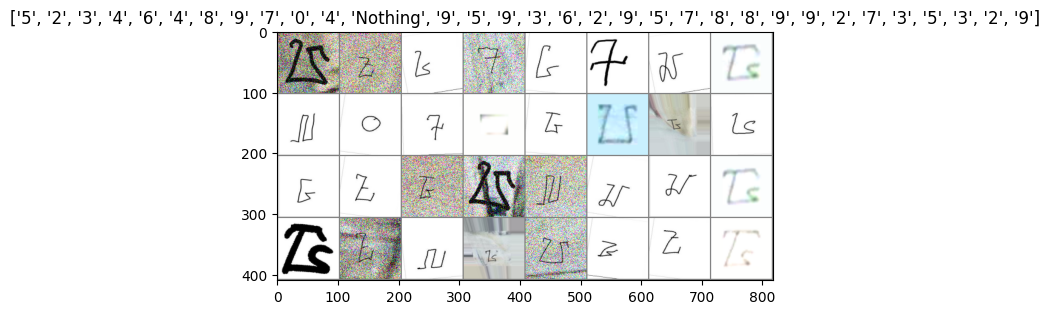

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training Model

In [24]:
def train_model(model, criterion, optimizer, scheduler, checkpoint, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_acc_array = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad(set_to_none=True)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):
                    # logits, outputs = model(inputs)
                    outputs = model(inputs)

                    # print(logits)
                    # print(outputs)
                    _, preds = torch.max(outputs, 1)
                    # print(preds.shape)
                    # print(inputs.shape)
                    # print(outputs.shape)
                    # print(outputs)
                    # print(labels.shape)
                    # print(labels)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            loss_acc_array.append('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './'+ checkpoint +'.pt')
                best_acc = epoch_acc
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,loss_acc_array

## Premade Model

In [25]:
model_18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

In [12]:
model_34 = models.resnet34(weights=ResNet34_Weights.DEFAULT)

## Training Model

In [26]:
def main(model, PATH, checkpoint):
    num_ftrs = model.fc.in_features
    # # Here the size of each output sample is set to 2.
    # # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)

    criterion = nn.NLLLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model,loss_acc_arr = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, checkpoint, num_epochs=10)

    print("/nSaving the model...")
    torch.save(model, PATH)
    print("/nModel Saved...")
    return model

In [27]:
os.remove('./model_18_'+main_folder+'.pth')
os.remove('./model_18_checkpoint_'+main_folder+'.pt')

In [28]:

model_18 = main(model_18, './model_18_'+main_folder+'.pth','model_18_checkpoint_'+main_folder)

Epoch 0/9
----------
Training Loss: -42.8470 Acc: 0.8000
Testing Loss: -95.1358 Acc: 0.9295

Epoch 1/9
----------
Training Loss: -154.1345 Acc: 0.9475
Testing Loss: -237.8215 Acc: 0.9429

Epoch 2/9
----------
Training Loss: -348.8863 Acc: 0.9673
Testing Loss: -461.6897 Acc: 0.9250

Epoch 3/9
----------
Training Loss: -641.5444 Acc: 0.9760
Testing Loss: -779.5259 Acc: 0.9149

Epoch 4/9
----------
Training Loss: -1012.8845 Acc: 0.9738
Testing Loss: -1243.6672 Acc: 0.9496

Epoch 5/9
----------
Training Loss: -1468.9734 Acc: 0.9862
Testing Loss: -1718.4201 Acc: 0.9642

Epoch 6/9
----------
Training Loss: -2000.9301 Acc: 0.9862
Testing Loss: -2348.1706 Acc: 0.9619

Epoch 7/9
----------
Training Loss: -2337.8075 Acc: 0.9944
Testing Loss: -2386.8365 Acc: 0.9776

Epoch 8/9
----------
Training Loss: -2396.9066 Acc: 0.9966
Testing Loss: -2444.3747 Acc: 0.9720

Epoch 9/9
----------
Training Loss: -2452.1462 Acc: 0.9966
Testing Loss: -2499.3709 Acc: 0.9765

Training complete in 2m 32s
Best val Acc

In [13]:
model_34 = main(model_34, './model_34_'+main_folder+'.pth','model_34_checkpoint_'+main_folder)

Epoch 0/9
----------
Training Loss: -141.6852 Acc: 0.9405
Testing Loss: -161.1044 Acc: 0.3625

Epoch 1/9
----------
Training Loss: -647.5236 Acc: 0.9862
Testing Loss: -509.5964 Acc: 0.3006

Epoch 2/9
----------
Training Loss: -1542.3422 Acc: 0.9909
Testing Loss: -1072.1677 Acc: 0.3324

Epoch 3/9
----------
Training Loss: -2852.6923 Acc: 0.9950
Testing Loss: -1957.9932 Acc: 0.2938

Epoch 4/9
----------
Training Loss: -4577.7562 Acc: 1.0000
Testing Loss: -3046.9616 Acc: 0.2619

Epoch 5/9
----------
Training Loss: -6698.4171 Acc: 1.0000
Testing Loss: -4341.2370 Acc: 0.2415

Epoch 6/9
----------
Training Loss: -9192.2275 Acc: 1.0000
Testing Loss: -5991.9897 Acc: 0.2932

Epoch 7/9
----------
Training Loss: -10701.2082 Acc: 1.0000
Testing Loss: -6096.2745 Acc: 0.3409

Epoch 8/9
----------
Training Loss: -10959.2787 Acc: 1.0000
Testing Loss: -6110.1521 Acc: 0.2369

Epoch 9/9
----------
Training Loss: -11202.8321 Acc: 1.0000
Testing Loss: -6381.9794 Acc: 0.3148

Training complete in 6m 2s
Best

# Model Summary

In [14]:
from torchsummary import summary

summary(model_18,(3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

In [15]:
from torchsummary import summary

summary(model_34,(3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

# Testing with New Data

In [29]:
def testing(data_path, model_pth):
    transform = transforms.Compose([
            # transforms.RandomResizedCrop(219),
            # transforms.RandomHorizontalFlip(),
            # transforms.Resize(28),

            transforms.ToTensor(),
            # transforms.Normalize([0.485], [0.229])
            # transforms.Normalize([0.5], [0.5])
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Nothing']

    # img = Image.open('./Ka28x28.jpg').convert('RGB')
    img = Image.open(data_path).convert('RGB').resize((100,100))
    plt.imshow(img)

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.to(device)

    model_ft = torch.load(model_pth)
    model_ft.eval()
    out = model_ft(batch_t)
    values, preds = torch.max(out, 1)
    # print(img)
    # print(out)
    print(preds)
    # print(class_names[preds[0]])
    plt.title(model_pth)
    plt.xlabel('Prediction : '+ class_names[preds[0]])
    # logits, out = model_ft(batch_t)
    sm = torch.nn.Softmax(dim=1)
    top_out = sm(out)
    top_prob, top_label = torch.topk(top_out,3)
    print(top_prob, top_label)
    print("top_prob : "+ str(top_prob[0][0].cpu().detach().numpy()), "top_label :"+ str(top_label[0][0].cpu().detach().numpy()))
    return class_names[preds[0]]

tensor([10], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[10,  1,  0]], device='cuda:0')
top_prob : 1.0 top_label :10


'Nothing'

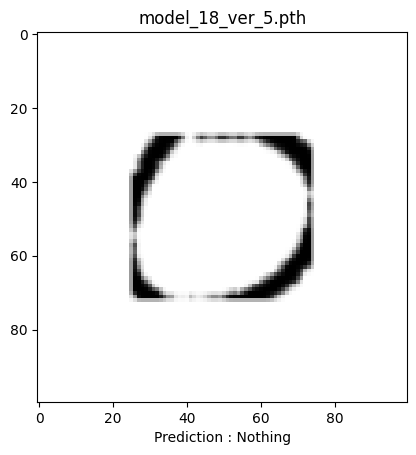

In [30]:
path = r"data\trainingData\ver_5\Nothing\ (43).png"
testing(path,'model_18_'+main_folder+'.pth')

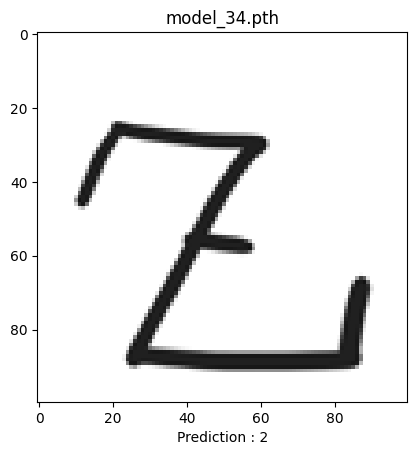

In [27]:
testing('.//data//test//angka//2.jpg','model_34.pth')

tensor([1], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<TopkBackward0>) tensor([[1, 2, 0]], device='cuda:0')
top_prob : 1.0 top_label :1


'1'

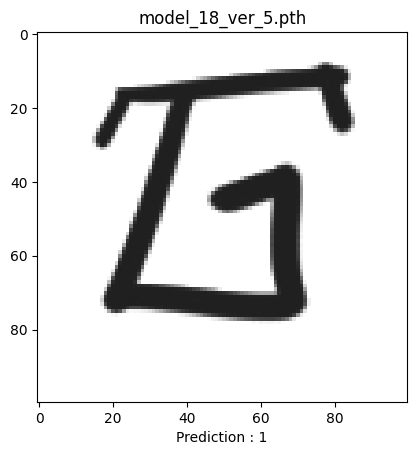

In [31]:
testing('.//data//test//angka//1.jpg','model_18_'+main_folder+'.pth')

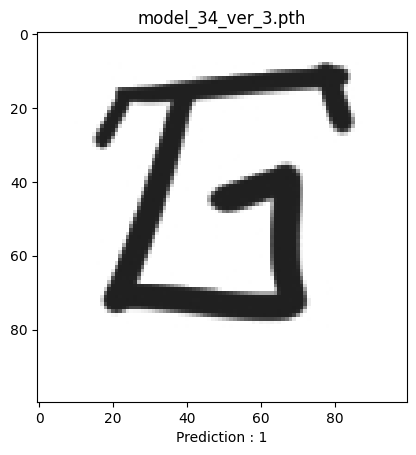

In [20]:
testing('.//data//test//angka//1.jpg','model_34_ver_3.pth')


# Character Segmentation

## Get Dominant Color for Padding

In [32]:
from sklearn.cluster import KMeans
from collections import Counter
import cv2 #for resizing image

def get_dominant_color(image, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)


## Predicting Function

In [33]:
def predict(data_path, model_pth):
    transform = transforms.Compose([
            # transforms.RandomResizedCrop(219),
            # transforms.RandomHorizontalFlip(),
            # transforms.Resize(28),

            transforms.ToTensor(),
            # transforms.Normalize([0.485], [0.229])
            # transforms.Normalize([0.5], [0.5])
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','Nothing']

    # img = Image.open('./Ka28x28.jpg').convert('RGB')
    img = Image.fromarray(data_path).convert('RGB').resize((100,100))

    plt.imshow(img)

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.to(device)

    model_ft = torch.load(model_pth)
    model_ft.eval()
    out = model_ft(batch_t)
    values, preds = torch.max(out, 1)
    # print(out)
    # print(preds)
    # print(class_names[preds[0]])
    plt.title(model_pth)
    plt.xlabel('Prediction : '+ class_names[preds[0]])
    # logits, out = model_ft(batch_t)

    sm = torch.nn.Softmax(dim=1)
    top_out = sm(out)
    top_prob, top_label = torch.topk(top_out,3)
    # print(top_prob, top_label)
    # print("top_prob : "+ str(top_prob[0][0].cpu().detach().numpy()), "top_label :"+ str(top_label[0][0].cpu().detach().numpy()))
    prob = top_prob[0][0].cpu().detach().numpy()
    label = "top_label :"+ str(top_label[0][0].cpu().detach().numpy())
    # return class_names[preds[0]]+" "+prob + "%"
    return (class_names[preds[0]], prob)

## NMS for Bounding Boxes

In [21]:
def nms_pytorch(P : torch.tensor ,thresh_iou : float):
    """
    Apply non-maximum suppression to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the image 
            along with the class predscores, Shape: [num_boxes,5].
        thresh_iou: (float) The overlap thresh for suppressing unnecessary boxes.
    Returns:
        A list of filtered boxes, Shape: [ , 5]
    """
 
    # we extract coordinates for every 
    # prediction box present in P
    x1 = P[:, 0]
    y1 = P[:, 1]
    x2 = P[:, 2]
    y2 = P[:, 3]
 
    # we extract the confidence scores as well
    scores = P[:, 4]
 
    # calculate area of every block in P
    areas = (x2 - x1) * (y2 - y1)
     
    # sort the prediction boxes in P
    # according to their confidence scores
    order = scores.argsort()
 
    # initialise an empty list for 
    # filtered prediction boxes
    keep = []
     
 
    while len(order) > 0:
         
        # extract the index of the 
        # prediction with highest score
        # we call this prediction S
        idx = order[-1]
 
        # push S in filtered predictions list
        keep.append(P[idx])
 
        # remove S from P
        order = order[:-1]
 
        # sanity check
        if len(order) == 0:
            break
         
        # select coordinates of BBoxes according to 
        # the indices in order
        xx1 = torch.index_select(x1,dim = 0, index = order)
        xx2 = torch.index_select(x2,dim = 0, index = order)
        yy1 = torch.index_select(y1,dim = 0, index = order)
        yy2 = torch.index_select(y2,dim = 0, index = order)
 
        # find the coordinates of the intersection boxes
        xx1 = torch.max(xx1, x1[idx])
        yy1 = torch.max(yy1, y1[idx])
        xx2 = torch.min(xx2, x2[idx])
        yy2 = torch.min(yy2, y2[idx])
 
        # find height and width of the intersection boxes
        w = xx2 - xx1
        h = yy2 - yy1
         
        # take max with 0.0 to avoid negative w and h
        # due to non-overlapping boxes
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
 
        # find the intersection area
        inter = w*h
 
        # find the areas of BBoxes according the indices in order
        rem_areas = torch.index_select(areas, dim = 0, index = order) 
 
        # find the union of every prediction T in P
        # with the prediction S
        # Note that areas[idx] represents area of S
        union = (rem_areas - inter) + areas[idx]
         
        # find the IoU of every prediction in P with S
        IoU = inter / union
 
        # keep the boxes with IoU less than thresh_iou
        mask = IoU < thresh_iou
        order = order[mask]
     
    return keep

## Region of Ineterest (ROI) Detection

In [36]:
model_ft = torch.load('.\model_18_ver_5.pth')
model_ft.eval()
def predict(data_path):
    transform = transforms.Compose([
            # transforms.RandomResizedCrop(219),
            # transforms.RandomHorizontalFlip(),
            # transforms.Resize(28),

            transforms.ToTensor(),
            # transforms.Normalize([0.485], [0.229])
            # transforms.Normalize([0.5], [0.5])
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9','Nothing']

    img = Image.fromarray(data_path).convert('RGB').resize((100,100))

    plt.imshow(img)

    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.to(device)

    out = model_ft(batch_t)
    values, preds = torch.max(out, 1)

    sm = torch.nn.Softmax(dim=1)
    top_out = sm(out)
    top_prob, top_label = torch.topk(top_out,3)
    prob = top_prob[0][0].cpu().detach().numpy()
    label = "top_label :"+ str(top_label[0][0].cpu().detach().numpy())
    return (class_names[preds[0]], prob)

In [42]:
def boxing(img, dilateIteration, erodeIteration, alpha, beta):
    image = img
    # image = cv2.imread(".\\data\\test\\angka\\all.png")
    try:
        # alpha = float(input('* Enter the alpha value [1.0-3.0]: '))
        # beta = int(input('* Enter the beta value [0-100]: '))
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    except ValueError:
        print('Error, not a number')

    # image = cv2.resize(image, (400,400))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # blur = cv2.GaussianBlur(gray, (2, 2), 0)
    canny = cv2.Canny(gray,30,250)

    # threshold the image
    # ret,th3 = cv2.threshold(gray ,200,255,cv2.THRESH_BINARY)
    # th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
    # th3 = cv2.adaptiveThreshold(canny,200,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,11)
    ret3,th3 = cv2.threshold(canny,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    # dilate the white portions
    dilate = cv2.dilate(th3, None, iterations=dilateIteration)
    erode = cv2.erode(dilate,None,iterations=erodeIteration)

    kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(3, 3))
    erode = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, kernel, iterations=4)
    
    # find contours in the image
    # connectivity = 8  # You need to choose 4 or 8 for connectivity type
    # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erode , connectivity , cv2.CV_32S)

    # cnts = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    # cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    mser = cv2.MSER_create()
    mser.setMaxArea(int(400*400/2))
    regions, rects = mser.detectRegions(erode)


    orig = image.copy()
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.3
    fontColor              = (0,0,0)
    thickness              = 1
    lineType               = 1

    i = 0
    # P = []
    # for cnt in cnts:
    #     # Check the area of contour, if it is very small ignore it
    #     if(cv2.contourArea(cnt) < 100):
    #         # print(cv2.contourArea(cnt))
    #         continue

    #     # Filtered countours are detected
    #     x,y,w,h = cv2.boundingRect(cnt)

    #     # Taking ROI of the cotour
    #     roi = image[y:y+h, x:x+w]
    #     prediction = predict(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    #     # print(prediction)
    #     if(prediction[0] == "Nothing"):
    #         continue
    #     P.append([x,y,w,h,prediction[1].tolist()])


    #     # cv2.imwrite("roi" + str(i) + ".png", roi)
    #     i = i + 1
    # print(P)
    # P = torch.tensor(P)
    # # print(P) 
    # filtered_box=nms_pytorch(P,0.5)
    # # print("filtered_box : "+ str(filtered_box))

    i = 0
    for roi in rects:
        # print(roi.numpy())
        # x = stats[j, cv2.CC_STAT_LEFT]
        # y = stats[j, cv2.CC_STAT_TOP]
        # w = stats[j, cv2.CC_STAT_WIDTH]
        # h = stats[j, cv2.CC_STAT_HEIGHT]
        x,y,w,h = roi
        # x,y,w,h = cv2.boundingRect(roi)
        # x,y,w,h,prob = roi.numpy().astype(int)
        # print(x,y,w,h,prob)
        
        roi = image[y:y+h, x:x+w]
        
        value = get_dominant_color(roi, k=4, image_processing_size = (100,100))
        
        # roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, [255,255,255])
        roi = cv2.copyMakeBorder(roi, 10, 10, 10, 10, cv2.BORDER_CONSTANT, None, value)
        roi_resize = cv2.resize(roi, (100,100))

        prediction = predict(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        cv2.imwrite("./gathered_data/"+str(prediction[0])+"/"+str(int(time.time()))+str(i)+".png", roi_resize)
        
        if(prediction[0] == "Nothing"):
            continue
        cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(orig,str(prediction[0])+" " + str(round(prediction[1]*100,2)) + " %", 
            # (x+int(w/2),y+int(h)),
            (x,y),  
            font, 
            fontScale,
            fontColor,
            thickness,
            lineType)
        i = i + 1

    return (image, erode, orig)


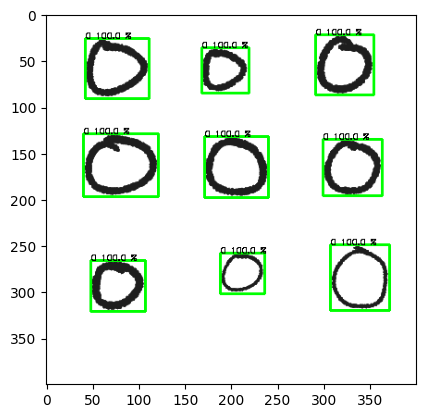

In [44]:
image = cv2.imread("0.png")
img_process = boxing(image, 2, 1, 1.5, 30)

# for i in range(3):
#     plt.subplot(1,3,(i+1)),plt.imshow(img_process[i])

plt.imshow(img_process[2])

plt.show()

## Lampiran

('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
('3', array(1., dtype=float32))
tensor([[ 19., 255.,  87.,  82.,   1.],
        [163., 251.,  84.,  80.,   1.],
        [270., 244.,  85.,  78.,   1.],
        [ 34., 143.,  69.,  84.,   1.],
        [165., 136.,  83.,  72.,   1.],
        [278., 128.,  86.,  74.,   1.],
        [ 27.,  25.,  81.,  80.,   1.],
        [274.,  18.,  85.,  80.,   1.],
        [164.,  17.,  74.,  79.,   1.]])
filtered_box : [tensor([164.,  17.,  74.,  79.,   1.]), tensor([274.,  18.,  85.,  80.,   1.]), tensor([27., 25., 81., 80.,  1.]), tensor([278., 128.,  86.,  74.,   1.]), tensor([165., 136.,  83.,  72.,   1.]), tensor([ 34., 143.,  69.,  84.,   1.]), tensor([270., 244.,  85.,  78.,   1.]), tensor([163., 251.,  84.,  80.,   1.]), tensor([ 19., 255., 

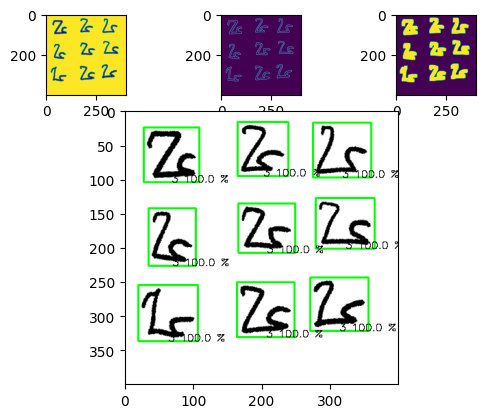

In [ ]:
# image = cv2.imread(".//data//test//angka//2_camera.jpg")
image = cv2.imread("3.png")

image = cv2.resize(image, (400,400))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(blur,0,200)

# threshold the image
# ret,th3 = cv2.threshold(gray ,200,255,cv2.THRESH_BINARY)
# th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
# th3 = cv2.adaptiveThreshold(canny,200,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,11)
ret3,th3 = cv2.threshold(canny,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# dilate the white portions
dilate = cv2.dilate(th3, None, iterations=6)
erode = cv2.erode(dilate,None,iterations=1)
# find contours in the image
cnts = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
# cnts = cnts[0] if imutils.is_cv2() else cnts[1]

orig = image.copy()
font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
thickness              = 1
lineType               = 1


i = 0
P = []
for cnt in cnts:
    # Check the area of contour, if it is very small ignore it
    if(cv2.contourArea(cnt) < 100):
        # print(cv2.contourArea(cnt))
        continue

    # Filtered countours are detected
    x,y,w,h = cv2.boundingRect(cnt)

    # Taking ROI of the cotour
    roi = image[y:y+h, x:x+w]
    prediction = predict(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB),'model_18_'+main_folder+'.pth')
    print(prediction)
    if(prediction[0] == "Nothing"):
        continue
    P.append([x,y,w,h,prediction[1].tolist()])


    # cv2.imwrite("roi" + str(i) + ".png", roi)
    i = i + 1
P = torch.tensor(P)
print(P) 
filtered_box=nms_pytorch(P,0.8)
print("filtered_box : "+ str(filtered_box))

i = 0
for roi in filtered_box:
    print(roi.numpy())
    x,y,w,h,prob = roi.numpy().astype(int)
    print(x,y,w,h,prob)
    
    roi = image[y:y+h, x:x+w]
    
    value = get_dominant_color(roi, k=4, image_processing_size = (100,100))
    
    # roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, [255,255,255])
    roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, value)
    
    prediction = predict(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB),'model_18_'+main_folder+'.pth')

    cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(orig,str(prediction[0])+" " + str(prediction[1]*100) + " %", 
        (x+int(w/2),y+int(h)),
        # (x,y),  
        font, 
        fontScale,
        fontColor,
        thickness,
        lineType)
    roi = cv2.resize(roi, (100,100))
    # cv2.imwrite("./data/ver_4/Nothing/Nothing" + str(i) + ".png", roi)
    i = i + 1



images = [blur,th3,erode,orig]
for i in range(3):
    plt.subplot(4,3,(i+1)),plt.imshow(images[i])
    # plt.title(titles[i])
    # plt.xticks([]),plt.yticks([])

plt.subplot(4,3,(4,12)),plt.imshow(images[3])
# plt.imshow(images[3])
plt.show()


In [ ]:
import cv2
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for j in class_names:
    image = cv2.imread("./"+j+".png")
    # image = cv2.imread(".//data//test//angka//all.png")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur,0,200)

    # threshold the image
    # ret,th3 = cv2.threshold(gray ,200,255,cv2.THRESH_BINARY)
    # th3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,2)
    # th3 = cv2.adaptiveThreshold(canny,200,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,11)
    ret3,th3 = cv2.threshold(canny,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    # dilate the white portions
    dilate = cv2.dilate(th3, None, iterations=1)
    erode = cv2.erode(dilate,None,iterations=1)
    # find contours in the image
    cnts = cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
    # cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    orig = image.copy()
    i = 0
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.5
    fontColor              = (0,0,0)
    thickness              = 1
    lineType               = 1


    for cnt in cnts:
        # Check the area of contour, if it is very small ignore it
        if(cv2.contourArea(cnt) < 100):
            # print(cv2.contourArea(cnt))
            continue

        # Filtered countours are detected
        x,y,w,h = cv2.boundingRect(cnt)

        # Taking ROI of the cotour
        roi = image[y:y+h, x:x+w]
        print(i, x,y,w,h)
        # Mark them on the image if you want
        value = get_dominant_color(roi, k=4, image_processing_size = (100,100))
        # roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, value)
        roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, [255,255,255])

        prediction = str(predict(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB),'model_18_'+main_folder+'.pth'))
        cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.putText(orig,prediction, 
            # (x+int(w/2),y+int(h/2)),
            (x,y),  
            font, 
            fontScale,
            fontColor,
            thickness,
            
            lineType)
        
        roi = cv2.resize(roi, (100,100))
        cv2.imwrite("./data/ver_4/"+j+"/roi" + str(i) + ".png", roi)
        i = i + 1 

    # images = [  blur,th3,erode,orig]
    # # for i in range(3):
    # #     plt.subplot(4,3,(i+1)),plt.imshow(images[i])
    # #     # plt.title(titles[i])
    # #     # plt.xticks([]),plt.yticks([])

    # # plt.subplot(4,3,(4,12)),plt.imshow(images[3])
    # plt.imshow(images[3])
    # plt.show()
